In [1]:
# import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# from math import comb

import wecopttool as wot
import os
import Pioneer_Inverted_Pendulum as pip
from scipy.optimize import Bounds

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

wot.set_loglevel('ERROR', capytaine=False)
data_path = os.path.join('pioneer_data')

In [2]:
wavefreq = 0.325
f1_reg = wavefreq
nfreq_reg = 5
amplitude = 0.15

waves_regular = wot.waves.regular_wave(f1_reg, nfreq_reg, wavefreq, amplitude)
control_type = "PI"

In [3]:
NPIP = pip.NonlinearInvertedPendulumPTO(f1 = f1_reg,
                                        nfreq = nfreq_reg,
                                        ndof = 1,
                                        control_type = control_type)

In [4]:
LinPIP = pip.LinearizedInvertedPendulumPTO(f1 = f1_reg,
                                        nfreq = nfreq_reg,
                                        ndof = 1,
                                        control_type = control_type)

In [5]:
wec_nl = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq_reg, 
                                            f_add = NPIP.f_add,
                                            constraints = NPIP.constraints)
wec_lin = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq_reg, 
                                            f_add = LinPIP.f_add,
                                            constraints = LinPIP.constraints)  

In [6]:
res_lin = LinPIP.solve(wec_lin, waves_regular)
x_wec_0, x_opt_0 = wec_lin.decompose_state(res_lin[0].x)


Linearized wave 0, exit mode: 0, nit: 25, cntr: PI, avg. power: -50.19W


In [7]:
res_nl = NPIP.solve(wec_nl, waves_regular, x_wec_0, x_opt_0)


NonLin wave 0, exit mode: 9, nit: 200, cntr: PI, avg. power: 4.46W
Exit mode 9 encountered, trying again...
NonLin wave 0, exit mode: 9, nit: 200, cntr: PI, avg. power: 4.46W
Exit mode 9 encountered, trying again...
NonLin wave 0, exit mode: 9, nit: 200, cntr: PI, avg. power: 4.46W
Exit mode 9 encountered, trying again...


In [8]:
nsubsteps = 5
wec_fdom_list, wec_tdom_list, pen_fdom_list, pen_tdom_list = NPIP.post_process(wec_nl, res_nl, waves_regular, nsubsteps=nsubsteps)
wec_fdom, wec_tdom, pen_fdom, pen_tdom = wec_fdom_list[0], wec_tdom_list[0], pen_fdom_list[0], pen_tdom_list[0]

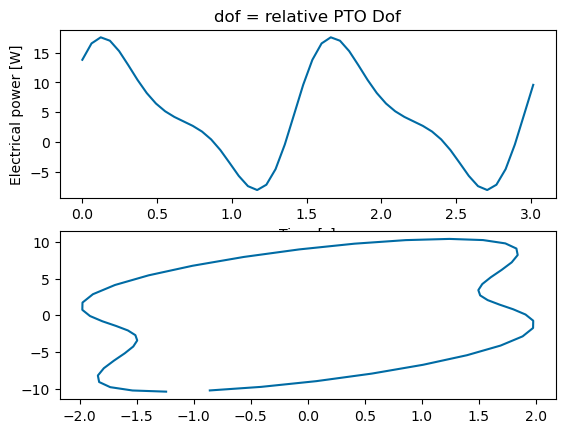

In [9]:

fig, axes = plt.subplots(2,1)
pen_tdom['epower'].plot(ax = axes[0])

axes[1].plot(pen_tdom['rel_vel'], pen_tdom['torque'].sel(type = 'Generator'))


In [10]:
wec_fdom.freq

<xarray.DataArray 'freq' (omega: 6)> Size: 48B
array([0.   , 0.325, 0.65 , 0.975, 1.3  , 1.625])
Coordinates:
  * omega        (omega) float64 48B 0.0 2.042 4.084 6.126 8.168 10.21
    freq         (omega) float64 48B 0.0 0.325 0.65 0.975 1.3 1.625
    period       (omega) float64 48B inf 3.077 1.538 1.026 0.7692 0.6154
    realization  int32 4B 0
Attributes:
    long_name:  Frequency
    units:      Hz

In [11]:
waves_regular.omega**2

<xarray.DataArray 'omega' (omega: 5)> Size: 40B
array([  4.16990786,  16.67963144,  37.52917074,  66.71852575,
       104.24769649])
Coordinates:
  * omega    (omega) float64 40B 2.042 4.084 6.126 8.168 10.21
    freq     (omega) float64 40B 0.325 0.65 0.975 1.3 1.625

In [12]:
wave_number_deep = waves_regular.omega**2/9.81

np.expand_dims(wave_number_deep*1,axis=(1, 2)).shape

(5, 1, 1)

In [13]:
waves_regular.wave_direction.squeeze().values

array(0.)

In [14]:
np.angle(waves_regular).shape

(5, 1, 1)

In [15]:
np.rad2deg(np.angle(waves_regular) - np.expand_dims(wave_number_deep*1,axis=(1, 2))).shape

(5, 1, 1)

In [16]:
nfreq_reg

5

In [17]:
NPIP.nfreq

5

In [18]:
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches


def animate_results(IP,
                    wec_tdom,
                    pen_tdom,
                    waves):
    plt.rcParams["animation.html"] = "jshtml"
    plt.ioff()
    fig, ax = plt.subplots()

    # Set the limits of the plot
    xlim = [-1.2, 1.2]
    dx = xlim[1]-xlim[0]
    ylim0 = -0.8
    ylim = [ylim0, ylim0+dx]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    wave_number_deep = waves.omega**2/9.81

    spatial_x = np.linspace(xlim[0], xlim[1], 10)
    wave_elevations = np.zeros((len(spatial_x), len(pen_tdom['time'])))

    #phase shift waves
    for i, x in enumerate(spatial_x):
        manual_wave = wot.waves.elevation_fd(IP.f1, IP.nfreq, 
                                            directions=waves.wave_direction, 
                                            nrealizations=len(waves.realization), 
                                            amplitudes=np.abs(waves), 
                                            phases=np.rad2deg(np.angle(waves) - np.expand_dims(wave_number_deep*x,axis=(1, 2))))    
        wave_td = wot.time_results(manual_wave, pen_tdom['time'])
        wave_elevations[i, :] = wave_td[0, 0, :]
    # wave_line, = ax.plot(spatial_vec, wave_elevations[:, 0], color='b')

    #Inputs NPIP, or some Pen pen_tdom, wec_tdom

    frames = len(pen_tdom['time'])
    time = pen_tdom['time']
    wave_elev = wec_tdom['wave_elev'].squeeze()
    pendulum_angles = pen_tdom['pen_pos'].squeeze()  # Sine wave for the circle
    buoy_angles = wec_tdom['pos'].squeeze()
    pendulum_max_torque = (IP.pendulum_mass * pip._default_parameters['g'] * IP.pendulum_com )
    pendulum_torque_norm = pen_tdom['torque'].sel(type = 'Pendulum NL').squeeze() / pendulum_max_torque
    spring_torque_norm = pen_tdom['torque'].sel(type = 'Spring NL').squeeze() / pendulum_max_torque# 614.7460754866761  #max value numericall from the acutal used function
    friction_torque_rel = pen_tdom['torque'].sel(type = 'Friction NL').squeeze() /pendulum_max_torque
    # pendulum_inerta_torque_norm = pen_inertia_torque / pendulum_max_torque


    pto_torque = pen_tdom['torque'].sel(type = 'Generator').squeeze()
    pto_torque_rel = pto_torque / pendulum_max_torque
    pow_norm_factor = 200
    pto_elec_power = pen_tdom['epower'].squeeze()
    pto_elec_power_norm = pto_elec_power / pow_norm_factor

    # Rectangle and truncated cone parameters
    buoy_width = 1.8
    buoy_height = 0.6
    cone_height = 0.6
    cone_radius_top = buoy_width / 4  # Top radius matches half the rectangle width
    cone_radius_bottom = buoy_width /2 # Bottom radius matches the rectangle width

        
    delta_y = 0.2

    #zero pos vectors
    buoy_x = np.array([-buoy_width / 2, buoy_width / 2, buoy_width / 2, -buoy_width / 2, -buoy_width / 2])
    buoy_y = np.array([-buoy_height / 2, -buoy_height / 2, buoy_height / 2, buoy_height / 2, -buoy_height / 2]) + delta_y
    buoy_initial =  np.vstack((buoy_x, buoy_y))  

    cone_x = np.linspace(-cone_radius_bottom, cone_radius_bottom, 2)
    cone_y_top = np.full_like(cone_x, -buoy_height / 2) +delta_y # Top of the cone
    cone_y_bottom = cone_y_top - cone_height +delta_y # Bottom of the cone
    cone_top = np.vstack((cone_x, cone_y_top))
    cone_bottom = np.vstack((cone_x * (cone_radius_top / cone_radius_bottom), cone_y_bottom))
     
    cone_left_side = np.array([[cone_x[0], cone_y_top[0]], [cone_x[0] * (cone_radius_top / cone_radius_bottom), cone_y_bottom[0]]])
    cone_right_side = np.array([[cone_x[-1], cone_y_top[-1]], [cone_x[-1] * (cone_radius_top / cone_radius_bottom), cone_y_bottom[-1]]])
    
    len_pen = 0.5
    def torque_to_arc(pen_torque_norm):
        return (0, 90 * pen_torque_norm) if pen_torque_norm >= 0 else (90 * pen_torque_norm, 0)
    def plot_torque(torque, label, radius, color):
        th1, th2 = torque_to_arc(torque)
        arc = patches.Arc((0, 0), radius, radius, angle=90, theta1=th1, theta2=th2, color=color, linewidth=2, alpha = 0.5, label =label)
        ax.add_patch(arc)

    def animate(frame):
        plt.cla()  # Clear the current axes
        ax.plot(spatial_x, wave_elevations[:, frame], color='b')
        # Get the predefined angles for the current frame
        angle_pen = pendulum_angles[frame]
        angle_buoy = buoy_angles[frame]
        torque_pen = pendulum_torque_norm[frame].item()
        torque_spring = spring_torque_norm[frame].item()
        torque_friction = friction_torque_rel[frame].item()
        # torque_pen_inertia = pendulum_inerta_torque_norm[frame].item()

        torque_pto = pto_torque_rel[frame].item()
        power_pto = pto_elec_power_norm[frame].item()

        # Calculate the x and y coordinates of the pendulum
        x_pen = len_pen * np.sin(angle_pen)
        y_pen = len_pen * np.cos(angle_pen)

        
        # pendulum
        plt.plot([0, x_pen], [0, y_pen], 'r--')  # Dashed red line
        plt.plot(x_pen, y_pen, 'ro', markersize = 12)  # 'ro' means red color, circle marker

        # Rotate the rectangle using the predefined angle
        rotation_matrix = np.array([[np.cos(angle_buoy), -np.sin(angle_buoy)],
                                    [np.sin(angle_buoy), np.cos(angle_buoy)]])
        buoy_rotated = rotation_matrix @ buoy_initial
        plt.plot(buoy_rotated[0, :], buoy_rotated[1, :], color='green')  # Green rectangle
        

        # Rotate the truncated cone
        cone_rotated_top = rotation_matrix @ cone_top
        cone_rotated_bottom = rotation_matrix @ cone_bottom
        left_side_rotated = rotation_matrix @ cone_left_side.T
        right_side_rotated = rotation_matrix @ cone_right_side.T
        
        # Plot the truncated cone
        plt.plot(cone_rotated_top[0, :], cone_rotated_top[1, :], color='green')  # Top of the cone
        plt.plot(cone_rotated_bottom[0, :], cone_rotated_bottom[1, :], color='green')  # Bottom of the cone
        plt.plot(left_side_rotated[0, :], left_side_rotated[1, :], color='green')  # Left side of the cone
        plt.plot(right_side_rotated[0, :], right_side_rotated[1, :], color='green')  # Right side of the cone

        #power bar
        if power_pto < 0:
            plt.plot([1.1, 1.1],[0, 0-power_pto],  color='green', linewidth=10, alpha = 0.5)
        else:
            plt.plot([1.1, 1.1],[0, 0-power_pto],  color='red', linewidth=10, alpha = 0.5)
        plt.text(1.2, 0, f'{-1*power_pto*pow_norm_factor:.1f}W')
        
        #torques
        plot_torque(torque_pen, label='pen. gravit.',radius= 0.5, color='red')
        plot_torque(torque_spring, label='Spring',radius= 0.6, color='blue')
        plot_torque(torque_pto, label='PTO',radius= 0.4, color='orange')
        plot_torque(torque_friction, label='Friction',radius= 0.3, color='black')
  

        # Set the limits and aspect ratio
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_aspect('equal', adjustable='box')  
        ax.grid(True)  
        ax.legend(loc = 'upper left')
        ax.set_title(f'Time = {time[frame]:.2f}')  

    return FuncAnimation(fig, animate, frames=frames, interval=frames)

# Create the animation
ani = animate_results(NPIP,
                    wec_tdom,
                    pen_tdom,
                    waves_regular)
ani

In [19]:
# ani.save('pioneer_reg_'+f'{wavefreq}'.replace('.','p')+ control_type+ '.gif', writer='imagemagick', fps=1/(pen_tdom['time'][1]-pen_tdom['time'][0]))

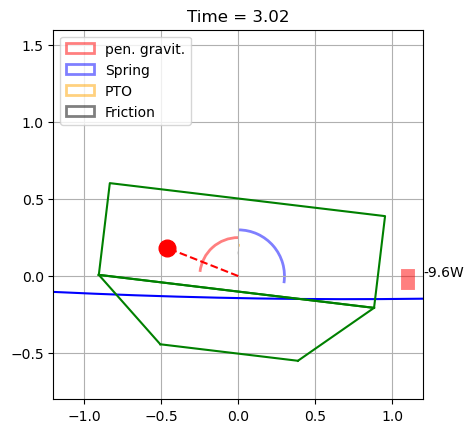

In [20]:
%matplotlib inline
plt.rcParams["animation.html"] = "none"
plt.show()

In [21]:
wec_fdom['wave_elev']

<xarray.DataArray 'wave_elev' (omega: 6, wave_direction: 1)> Size: 96B
array([[ 0.        +0.j        ],
       [-0.13630739-0.06261226j],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ]])
Coordinates:
  * omega           (omega) float64 48B 0.0 2.042 4.084 6.126 8.168 10.21
    freq            (omega) float64 48B 0.0 0.325 0.65 0.975 1.3 1.625
    period          (omega) float64 48B inf 3.077 1.538 1.026 0.7692 0.6154
  * wave_direction  (wave_direction) float64 8B 0.0
    realization     int32 4B 0
Attributes:
    units:                m
    long_name:            Wave elevation
    Wave type:            Regular
    Frequency (Hz):       0.325
    Amplitude (m):        0.15
    Phase (degrees):      None
    Direction (degrees):  0.0

In [22]:

# # Simulated wave elevation data
# # Assume time_steps is the number of time steps and spatial_points is the number of spatial points
# time_steps = 100
# spatial_points = 20
# x = np.linspace(-1, 1, spatial_points)  # Spatial coordinates from -1m to +1m
# t = np.linspace(0, 10, time_steps)  # Time from 0 to 10 seconds

# # Example wave elevation data (e.g., a sine wave)
# wave_elevation = np.sin(2 * np.pi * (x[:, None] - 0.1 * t[None, :]))

# # Set up the figure and axis
# fig, ax = plt.subplots()
# contour = ax.contourf(x, t, wave_elevation, levels=100, cmap='viridis')
# ax.set_xlabel('Position (m)')
# ax.set_ylabel('Time (s)')
# ax.set_title('Wave Elevation Propagation')

# # Animation function
# def update(frame):
#     ax.clear()
#     ax.contourf(x, t, wave_elevation, levels=100, cmap='viridis')
#     ax.set_xlabel('Position (m)')
#     ax.set_ylabel('Time (s)')
#     ax.set_title('Wave Elevation Propagation')
#     ax.set_ylim(0, 10)  # Keep the time axis fixed
#     ax.set_xlim(-1, 1)  # Keep the spatial axis fixed

# # Create animation
# ani = FuncAnimation(fig, update, frames=time_steps, repeat=True)
# ani

## outer loop wavefreq

In [33]:
wave_freq_vec = [0.3, 0.325, 0.35, 0.375]
nfreq = 5
amplitude = 0.15
cntrl_type = 'P'

res_list = []
P_pen_tdom_res_list = []

for wavefreq in wave_freq_vec:
    f1_reg = wavefreq
    waves_regular = wot.waves.regular_wave(f1_reg, nfreq, wavefreq, amplitude)
    NPIP = pip.NonlinearInvertedPendulumPTO(f1_reg, nfreq, ndof = 1, control_type = cntrl_type)
    LinPIP = pip.LinearizedInvertedPendulumPTO(f1_reg, nfreq, ndof = 1, control_type = cntrl_type)
    wec_lin = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq, f_add = LinPIP.f_add, constraints = LinPIP.constraints)  
    wec_nl = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq, f_add = NPIP.f_add, constraints = NPIP.constraints)
    res_lin = LinPIP.solve(wec_lin, waves_regular)
    x_wec_0, x_opt_0 = wec_lin.decompose_state(res_lin[0].x)
    res_nl = NPIP.solve(wec_nl, waves_regular, x_wec_0, x_opt_0)
    nsubsteps = 5
    wec_fdom_list, wec_tdom_list, pen_fdom_list, pen_tdom_list = NPIP.post_process(wec_nl, res_nl, waves_regular, nsubsteps=nsubsteps)
    wec_fdom, wec_tdom, pen_fdom, pen_tdom = wec_fdom_list[0], wec_tdom_list[0], pen_fdom_list[0], pen_tdom_list[0]
    res_list.append(res_nl[0])
    P_pen_tdom_res_list.append(pen_tdom)
    

Linearized wave 0, exit mode: 0, nit: 13, cntr: P, avg. power: -13.22W
NonLin wave 0, exit mode: 0, nit: 13, cntr: P, avg. power: -14.39W
Linearized wave 0, exit mode: 0, nit: 14, cntr: P, avg. power: -25.02W
NonLin wave 0, exit mode: 0, nit: 13, cntr: P, avg. power: -25.62W
Linearized wave 0, exit mode: 0, nit: 15, cntr: P, avg. power: -14.44W
NonLin wave 0, exit mode: 0, nit: 13, cntr: P, avg. power: -20.77W
Linearized wave 0, exit mode: 0, nit: 14, cntr: P, avg. power: -5.76W
NonLin wave 0, exit mode: 0, nit: 88, cntr: P, avg. power: -11.67W


[None, None, None, None]

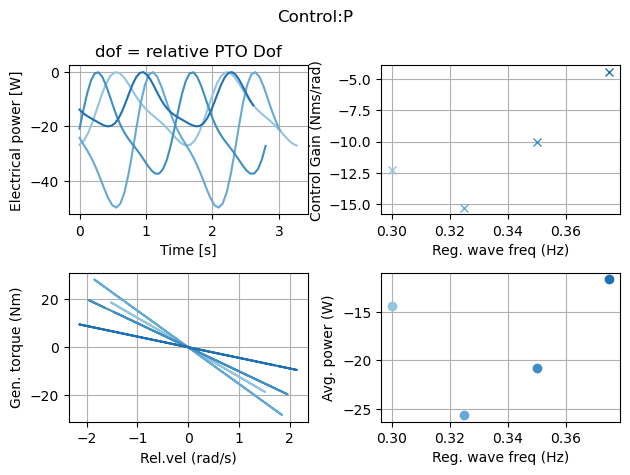

In [38]:
my_colors = plt.cm.Blues(np.linspace(0.4, 0.75, len(wave_freq_vec)))

fig, axes = plt.subplots(2,2, tight_layout = True)
fig.suptitle('Control:' + cntrl_type)
Pavg_list = []
for idx, pen_tdom in enumerate(P_pen_tdom_res_list):
    P_avg = np.mean(pen_tdom['epower']).values
    Pavg_list.append(P_avg)
    P_gain = res_list[idx].x[2*nfreq:-2*nfreq]
    # P_gain_Asprad = 
    pen_tdom['epower'].plot(ax = axes[0,0], color = my_colors[idx])
    axes[1,0].plot(pen_tdom['rel_vel'], pen_tdom['torque'].sel(type = 'Generator'), color = my_colors[idx])
    axes[0,1].plot(wave_freq_vec[idx], P_gain, 'x', color = my_colors[idx])
    axes[1,1].plot(wave_freq_vec[idx], P_avg, 'o', color = my_colors[idx])

axes[1,0].set_xlabel('Rel.vel (rad/s)')
axes[1,0].set_ylabel('Gen. torque (Nm)')
axes[1,1].set_xlabel('Reg. wave freq (Hz)')
axes[1,1].set_ylabel('Avg. power (W)')
axes[0,1].set_ylabel('Control Gain (Nms/rad)')
axes[0,1].set_xlabel('Reg. wave freq (Hz)')

[ax.grid(which = 'both') for ax in axes.flatten()]

In [25]:
cntrl_type = 'PI'

PI_res_list = []
PI_pen_tdom_res_list = []

for wavefreq in wave_freq_vec:
    f1_reg = wavefreq
    waves_regular = wot.waves.regular_wave(f1_reg, nfreq, wavefreq, amplitude)
    NPIP = pip.NonlinearInvertedPendulumPTO(f1_reg, nfreq, ndof = 1, control_type = cntrl_type)
    LinPIP = pip.LinearizedInvertedPendulumPTO(f1_reg, nfreq, ndof = 1, control_type = cntrl_type)
    wec_lin = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq, f_add = LinPIP.f_add, constraints = LinPIP.constraints)  
    wec_nl = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq, f_add = NPIP.f_add, constraints = NPIP.constraints)
    res_lin = LinPIP.solve(wec_lin, waves_regular)
    x_wec_0, x_opt_0 = wec_lin.decompose_state(res_lin[0].x)
    res_nl = NPIP.solve(wec_nl, waves_regular, x_wec_0, x_opt_0)
    nsubsteps = 5
    wec_fdom_list, wec_tdom_list, pen_fdom_list, pen_tdom_list = NPIP.post_process(wec_nl, res_nl, waves_regular, nsubsteps=nsubsteps)
    wec_fdom, wec_tdom, pen_fdom, pen_tdom = wec_fdom_list[0], wec_tdom_list[0], pen_fdom_list[0], pen_tdom_list[0]
    PI_res_list.append(res_nl[0])
    PI_pen_tdom_res_list.append(pen_tdom)

Linearized wave 0, exit mode: 0, nit: 39, cntr: PI, avg. power: -26.12W
NonLin wave 0, exit mode: 0, nit: 22, cntr: PI, avg. power: -15.58W
Linearized wave 0, exit mode: 0, nit: 34, cntr: PI, avg. power: -21.08W
NonLin wave 0, exit mode: 0, nit: 18, cntr: PI, avg. power: -28.17W
Linearized wave 0, exit mode: 0, nit: 37, cntr: PI, avg. power: -12.38W
NonLin wave 0, exit mode: 0, nit: 19, cntr: PI, avg. power: -21.91W
Linearized wave 0, exit mode: 0, nit: 37, cntr: PI, avg. power: -13.46W
NonLin wave 0, exit mode: 0, nit: 20, cntr: PI, avg. power: -11.76W


[None, None, None, None]

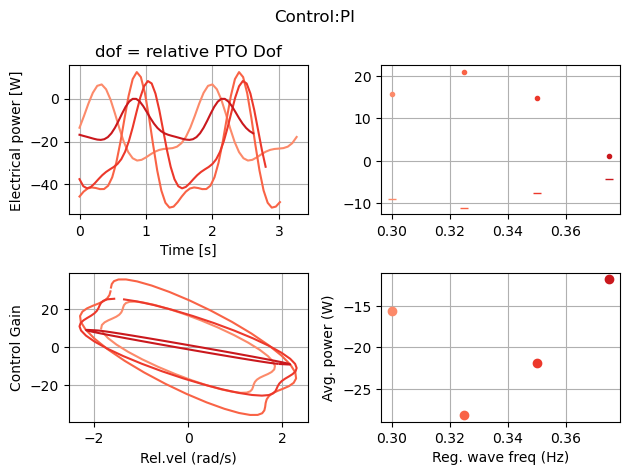

In [26]:
my_colors = plt.cm.Reds(np.linspace(0.4, 0.75, len(wave_freq_vec)))

fig, axes = plt.subplots(2,2, tight_layout = True)
fig.suptitle('Control:' + cntrl_type)
Pavg_list = []
for idx, pen_tdom in enumerate(PI_pen_tdom_res_list):
    P_avg = np.mean(pen_tdom['epower']).values
    Pavg_list.append(P_avg)
    PI_gain = PI_res_list[idx].x[2*nfreq:-2*nfreq]
    pen_tdom['epower'].plot(ax = axes[0,0], color = my_colors[idx])
    axes[1,0].plot(pen_tdom['rel_vel'], pen_tdom['torque'].sel(type = 'Generator'), color = my_colors[idx])
    axes[0,1].plot(wave_freq_vec[idx], PI_gain[0], '_', color = my_colors[idx])
    axes[0,1].plot(wave_freq_vec[idx], PI_gain[1], '.', color = my_colors[idx])

    axes[1,1].plot(wave_freq_vec[idx], P_avg, 'o', color = my_colors[idx])

axes[1,0].set_xlabel('Rel.vel (rad/s)')
axes[1,0].set_ylabel('Gen. torque (Nm)')
axes[1,1].set_xlabel('Reg. wave freq (Hz)')
axes[1,1].set_ylabel('Avg. power (W)')
axes[1,0].set_ylabel('Control Gain')

[ax.grid(which = 'both') for ax in axes.flatten()]

[None, None, None, None]

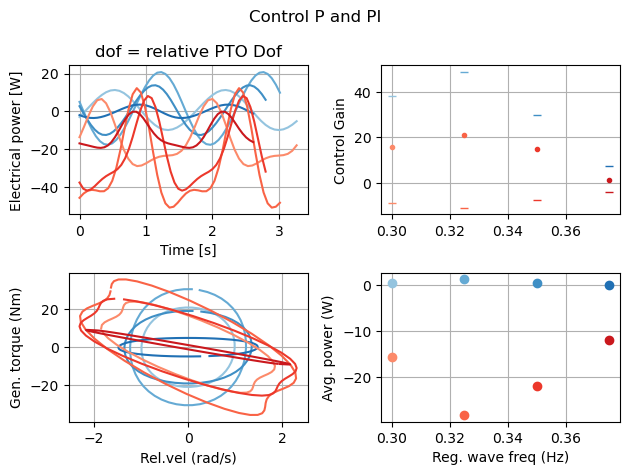

In [27]:
my_colors = [plt.cm.Blues(np.linspace(0.4, 0.75, len(wave_freq_vec))), 
             plt.cm.Reds(np.linspace(0.4, 0.75, len(wave_freq_vec)))]

fig, axes = plt.subplots(2,2, tight_layout = True)
fig.suptitle('Control P and PI')
Pavg_list = []
P_and_PI_pen_tdom_list = [P_pen_tdom_res_list, PI_pen_tdom_res_list]
P_and_PI_res_list = [res_list, PI_res_list]
Gain_marker_list = ['_','.']

for jdx, pen_tdom_res_list in enumerate(P_and_PI_pen_tdom_list):
    for idx, pen_tdom in enumerate(pen_tdom_res_list):
        P_avg = np.mean(pen_tdom['epower']).values
        Pavg_list.append(P_avg)
        C_gain = P_and_PI_res_list[jdx][idx].x[2*nfreq:-2*nfreq]
        pen_tdom['epower'].plot(ax = axes[0,0], color = my_colors[jdx][idx])
        axes[1,0].plot(pen_tdom['rel_vel'], pen_tdom['torque'].sel(type = 'Generator'), color = my_colors[jdx][idx])
        for ig, gain in enumerate(C_gain):
            axes[0,1].plot(wave_freq_vec[idx], gain, Gain_marker_list[ig], color = my_colors[jdx][idx])
        axes[1,1].plot(wave_freq_vec[idx], P_avg, 'o', color = my_colors[jdx][idx])

axes[1,0].set_xlabel('Rel.vel (rad/s)')
axes[1,0].set_ylabel('Gen. torque (Nm)')
axes[1,1].set_xlabel('Reg. wave freq (Hz)')
axes[1,1].set_ylabel('Avg. power (W)')
axes[0,1].set_ylabel('Control Gain')

[ax.grid(which = 'both') for ax in axes.flatten()]

In [28]:
cntrl_type = 'PID'

PID_res_list = []
PID_pen_tdom_res_list = []

for wavefreq in wave_freq_vec:
    f1_reg = wavefreq
    waves_regular = wot.waves.regular_wave(f1_reg, nfreq, wavefreq, amplitude)
    NPIP = pip.NonlinearInvertedPendulumPTO(f1_reg, nfreq, ndof = 1, control_type = cntrl_type)
    LinPIP = pip.LinearizedInvertedPendulumPTO(f1_reg, nfreq, ndof = 1, control_type = cntrl_type)
    wec_lin = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq, f_add = LinPIP.f_add, constraints = LinPIP.constraints)  
    wec_nl = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq, f_add = NPIP.f_add, constraints = NPIP.constraints)
    res_lin = LinPIP.solve(wec_lin, waves_regular)
    x_wec_0, x_opt_0 = wec_lin.decompose_state(res_lin[0].x)
    res_nl = NPIP.solve(wec_nl, waves_regular, x_wec_0, x_opt_0)
    nsubsteps = 5
    wec_fdom_list, wec_tdom_list, pen_fdom_list, pen_tdom_list = NPIP.post_process(wec_nl, res_nl, waves_regular, nsubsteps=nsubsteps)
    wec_fdom, wec_tdom, pen_fdom, pen_tdom = wec_fdom_list[0], wec_tdom_list[0], pen_fdom_list[0], pen_tdom_list[0]
    PID_res_list.append(res_nl[0])
    PID_pen_tdom_res_list.append(pen_tdom)

Linearized wave 0, exit mode: 0, nit: 31, cntr: PID, avg. power: -26.12W
NonLin wave 0, exit mode: 9, nit: 200, cntr: PID, avg. power: -15.97W
Exit mode 9 encountered, trying again...
NonLin wave 0, exit mode: 9, nit: 200, cntr: PID, avg. power: -15.97W
Exit mode 9 encountered, trying again...
NonLin wave 0, exit mode: 9, nit: 200, cntr: PID, avg. power: -15.97W
Exit mode 9 encountered, trying again...
Linearized wave 0, exit mode: 0, nit: 37, cntr: PID, avg. power: -50.19W
NonLin wave 0, exit mode: 0, nit: 47, cntr: PID, avg. power: -28.31W
Linearized wave 0, exit mode: 0, nit: 36, cntr: PID, avg. power: -31.26W
NonLin wave 0, exit mode: 9, nit: 200, cntr: PID, avg. power: -21.33W
Exit mode 9 encountered, trying again...
NonLin wave 0, exit mode: 9, nit: 200, cntr: PID, avg. power: -21.33W
Exit mode 9 encountered, trying again...
NonLin wave 0, exit mode: 9, nit: 200, cntr: PID, avg. power: -21.33W
Exit mode 9 encountered, trying again...
Linearized wave 0, exit mode: 0, nit: 37, cntr

[None, None, None, None]

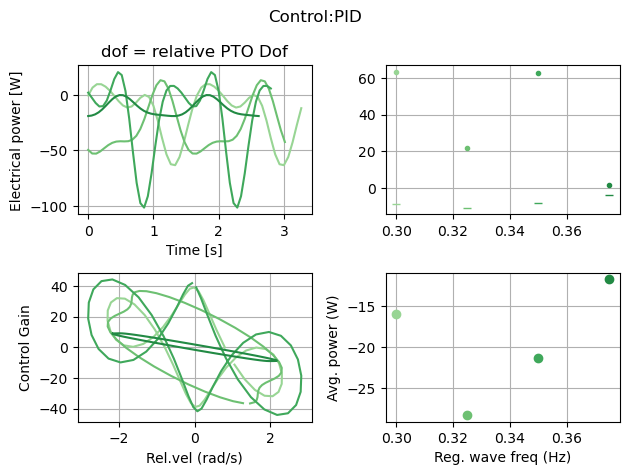

In [29]:
my_colors = plt.cm.Greens(np.linspace(0.4, 0.75, len(wave_freq_vec)))

fig, axes = plt.subplots(2,2, tight_layout = True)
fig.suptitle('Control:' + cntrl_type)
Pavg_list = []
for idx, pen_tdom in enumerate(PID_pen_tdom_res_list):
    P_avg = np.mean(pen_tdom['epower']).values
    Pavg_list.append(P_avg)
    PI_gain = PID_res_list[idx].x[2*nfreq:-2*nfreq]
    pen_tdom['epower'].plot(ax = axes[0,0], color = my_colors[idx])
    axes[1,0].plot(pen_tdom['rel_vel'], pen_tdom['torque'].sel(type = 'Generator'), color = my_colors[idx])
    axes[0,1].plot(wave_freq_vec[idx], PI_gain[0], '_', color = my_colors[idx])
    axes[0,1].plot(wave_freq_vec[idx], PI_gain[1], '.', color = my_colors[idx])

    axes[1,1].plot(wave_freq_vec[idx], P_avg, 'o', color = my_colors[idx])

axes[1,0].set_xlabel('Rel.vel (rad/s)')
axes[1,0].set_ylabel('Gen. torque (Nm)')
axes[1,1].set_xlabel('Reg. wave freq (Hz)')
axes[1,1].set_ylabel('Avg. power (W)')
axes[1,0].set_ylabel('Control Gain')

[ax.grid(which = 'both') for ax in axes.flatten()]

[None, None, None, None]

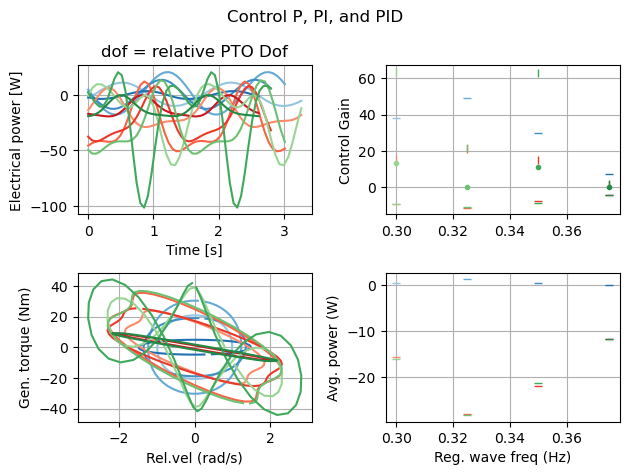

In [30]:
my_colors = [plt.cm.Blues(np.linspace(0.4, 0.75, len(wave_freq_vec))), 
             plt.cm.Reds(np.linspace(0.4, 0.75, len(wave_freq_vec))),
             plt.cm.Greens(np.linspace(0.4, 0.75, len(wave_freq_vec))),
             ]

fig, axes = plt.subplots(2,2, tight_layout = True)
fig.suptitle('Control P, PI, and PID')
Pavg_list = []
P_and_PI_pen_tdom_list = [P_pen_tdom_res_list, PI_pen_tdom_res_list, PID_pen_tdom_res_list]
P_and_PI_res_list = [res_list, PI_res_list, PID_res_list]
Gain_marker_list = ['_','|','.']

for jdx, pen_tdom_res_list in enumerate(P_and_PI_pen_tdom_list):
    for idx, pen_tdom in enumerate(pen_tdom_res_list):
        P_avg = np.mean(pen_tdom['epower']).values
        Pavg_list.append(P_avg)
        C_gain = P_and_PI_res_list[jdx][idx].x[2*nfreq:-2*nfreq]
        pen_tdom['epower'].plot(ax = axes[0,0], color = my_colors[jdx][idx])
        axes[1,0].plot(pen_tdom['rel_vel'], pen_tdom['torque'].sel(type = 'Generator'), color = my_colors[jdx][idx])
        for ig, gain in enumerate(C_gain):
            axes[0,1].plot(wave_freq_vec[idx], gain, Gain_marker_list[ig], color = my_colors[jdx][idx])
        axes[1,1].plot(wave_freq_vec[idx], P_avg, '_', color = my_colors[jdx][idx])

axes[1,0].set_xlabel('Rel.vel (rad/s)')
axes[1,0].set_ylabel('Gen. torque (Nm)')
axes[1,1].set_xlabel('Reg. wave freq (Hz)')
axes[1,1].set_ylabel('Avg. power (W)')
axes[0,1].set_ylabel('Control Gain')

[ax.grid(which = 'both') for ax in axes.flatten()]

In [31]:
cntrl_type = 'unstructured'

Uns_res_list = []
Uns_pen_tdom_res_list = []

for wavefreq in wave_freq_vec:
    f1_reg = wavefreq
    waves_regular = wot.waves.regular_wave(f1_reg, nfreq, wavefreq, amplitude)
    NPIP = pip.NonlinearInvertedPendulumPTO(f1_reg, nfreq, ndof = 1, control_type = cntrl_type)
    LinPIP = pip.LinearizedInvertedPendulumPTO(f1_reg, nfreq, ndof = 1, control_type = cntrl_type)
    wec_lin = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq, f_add = LinPIP.f_add, constraints = LinPIP.constraints)  
    wec_nl = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq, f_add = NPIP.f_add, constraints = NPIP.constraints)
    res_lin = LinPIP.solve(wec_lin, waves_regular)
    x_wec_0, x_opt_0 = wec_lin.decompose_state(res_lin[0].x)
    res_nl = NPIP.solve(wec_nl, waves_regular, x_wec_0, x_opt_0)
    nsubsteps = 5
    wec_fdom_list, wec_tdom_list, pen_fdom_list, pen_tdom_list = NPIP.post_process(wec_nl, res_nl, waves_regular, nsubsteps=nsubsteps)
    wec_fdom, wec_tdom, pen_fdom, pen_tdom = wec_fdom_list[0], wec_tdom_list[0], pen_fdom_list[0], pen_tdom_list[0]
    Uns_res_list.append(res_nl[0])
    Uns_pen_tdom_res_list.append(pen_tdom)

Linearized wave 0, exit mode: 0, nit: 50, cntr: unstructured, avg. power: -26.12W
NonLin wave 0, exit mode: 0, nit: 32, cntr: unstructured, avg. power: -16.19W
Linearized wave 0, exit mode: 0, nit: 49, cntr: unstructured, avg. power: -50.33W
NonLin wave 0, exit mode: 0, nit: 32, cntr: unstructured, avg. power: -29.10W
Linearized wave 0, exit mode: 0, nit: 51, cntr: unstructured, avg. power: -31.26W
NonLin wave 0, exit mode: 0, nit: 30, cntr: unstructured, avg. power: -22.32W
Linearized wave 0, exit mode: 0, nit: 50, cntr: unstructured, avg. power: -13.46W
NonLin wave 0, exit mode: 0, nit: 24, cntr: unstructured, avg. power: -11.95W


[None, None, None, None]

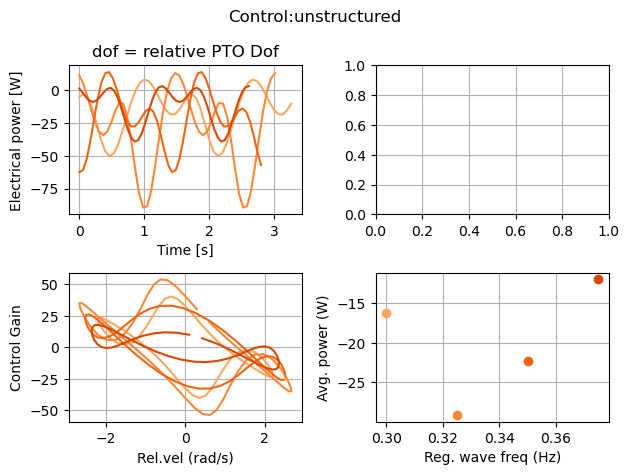

In [32]:
my_colors = plt.cm.Oranges(np.linspace(0.4, 0.75, len(wave_freq_vec)))

fig, axes = plt.subplots(2,2, tight_layout = True)
fig.suptitle('Control:' + cntrl_type)
Pavg_list = []
for idx, pen_tdom in enumerate(Uns_pen_tdom_res_list):
    P_avg = np.mean(pen_tdom['epower']).values
    Pavg_list.append(P_avg)
    # PI_gain = Uns_res_list[idx].x[2*nfreq:-2*nfreq]
    pen_tdom['epower'].plot(ax = axes[0,0], color = my_colors[idx])
    axes[1,0].plot(pen_tdom['rel_vel'], pen_tdom['torque'].sel(type = 'Generator'), color = my_colors[idx])
    # axes[0,1].plot(wave_freq_vec[idx], PI_gain[0], '_', color = my_colors[idx])
    # axes[0,1].plot(wave_freq_vec[idx], PI_gain[1], '.', color = my_colors[idx])

    axes[1,1].plot(wave_freq_vec[idx], P_avg, 'o', color = my_colors[idx])

axes[1,0].set_xlabel('Rel.vel (rad/s)')
axes[1,0].set_ylabel('Gen. torque (Nm)')
axes[1,1].set_xlabel('Reg. wave freq (Hz)')
axes[1,1].set_ylabel('Avg. power (W)')
axes[1,0].set_ylabel('Control Gain')

[ax.grid(which = 'both') for ax in axes.flatten()]